# Read the image

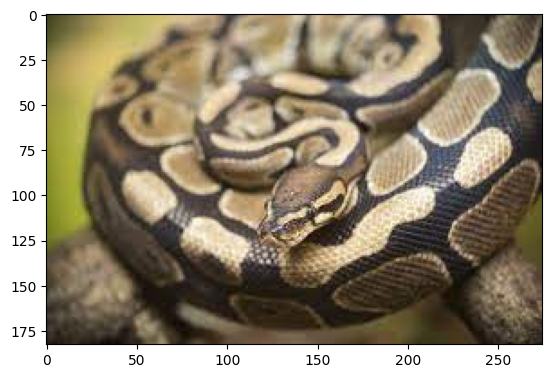

In [18]:
import numpy as np
import numba
from numba import cuda
import matplotlib.pyplot as plt
from matplotlib.image import imread
import time

rgb_image = imread('python.jpg')
plt.imshow(rgb_image)

## convert to hsv

In [19]:
from numba.typed import List

#scale image [0..255] to [0..1]
@cuda.jit(nopython=True)
def scale(x):
  x = x/255
  return x

#find max and min
@cuda.jit(nopython=True)
def min_and_max(red, green, blue, src):
  #find max
  if red > green and red > blue:
    max_c = (red, 0)
  elif green > red and green > blue:
    max_c = (green, 1)
  else:
    max_c = (blue, 2)

  #find min
  if red < green and red < blue:
    min_c = (red, 0)
  elif green < red and green < blue:
    min_c = (green, 1)
  else:
    min_c = (blue, 2)

  delta = max_c[0] - min_c[0]

  return (max_c, min_c, delta)

@cuda.jit
def rgb2hsv(src, dst):
    tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
    g = np.float32(((src[tidx, 0] + src[tidx, 1] + src[tidx, 2]) / 3))

    red = scale(np.float32(src[tidx, 0]))
    green = scale(np.float32(src[tidx, 1]))
    blue = scale(np.float32(src[tidx, 2]))

    # min_c, max_c, delta = min_and_max(red, green, blue, src)
    max_c, min_c, delta = min_and_max(red, green, blue, src)
    H = 0
    S = 0
    V = 0
    if delta == 0:
      H = 0
    elif max_c[1] == 0:
      H = 60*(((green-blue)/delta)%6)
    elif max_c[1] == 1:
      H = 60*(((blue-red)/delta)+2)
    else:
      H = 60*(((red-green)/delta)+4)

    if max_c[0] == 0:
      S = 0
    else:
      S = delta/max_c[0]

    V = max_c[0]

    dst[tidx, 0] = H
    dst[tidx, 1] = S
    dst[tidx, 2] = V

## convert to rgb

In [20]:
@cuda.jit
def hsv2rgb(src, dst):
    tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x

    H = src[tidx, 0]
    S = src[tidx, 1]
    V = src[tidx, 2]

    d = H/60
    hi = int(d)%6
    f = d - hi

    l = V*(1-S)
    m = V*(1-f*S)
    n = V*(1-(1-f)*S)

    if H>=0 and H < 60:
      first_c = V
      second_c = n
      third_c = l
    elif H >= 60 and H < 120:
      first_c = m
      second_c = V
      third_c = l
    elif H >= 120 and H < 180:
      first_c = l
      second_c = V
      third_c = n
    elif H >= 180 and H < 240:
      first_c = l
      second_c = m
      third_c = V
    elif H >= 240 and H < 300:
      first_c = n
      second_c = l
      third_c = V
    else:
      first_c = V
      second_c = l
      third_c = m
    #dst[tidx, 0] = 255
    #dst[tidx, 1] = 128
    #dst[tidx, 2] = 128
    dst[tidx, 0] = first_c*255
    dst[tidx, 1] = second_c*255
    dst[tidx, 2] = third_c*255

# Using only CPU

In [21]:
# • Parameter ω as window size
# • Convert RGB to HSV (SCATTER)
# • For each pixel Φ(i, j)
# • Define use 4 windows Wk
# , k ∈ [1..4] of size (ω + 1) × (ω + 1)
# • W1x ∈ [i − ω, i], W1y ∈ [j − ω, j]
# • W2x ∈ [i, i + ω], W2y ∈ [j − ω, j]
# • W3x ∈ [i − ω, i], W3y ∈ [j, j + ω]
# • W4x ∈ [i, i + ω], W4y ∈ [j, j + ω

In [22]:
# import numpy as np
# import cv2

# def kuwahara_filter(image, window_size):
#     h, w, _ = image.shape
#     pad = window_size // 2
#     output = np.zeros((h, w, 3))

#     print('before pad: ', image.size)

#     # pad the image
#     image = cv2.copyMakeBorder(image, pad, pad, pad, pad, cv2.BORDER_REFLECT)

#     print('after pad: ', image.size)

#     # convert image to hsv
#     # flatten the image into a 1D array of RGB
#     imageWidth, imageHeight = image.shape[0], image.shape[1]
#     pixel_count = imageWidth * imageHeight
#     blockSize = 1024
#     gridSize = int(pixel_count / blockSize)

#     rgb_flat_1 = image.reshape(pixel_count, 3)

#     start_time_gpu = time.time()
#     devSrc = cuda.to_device(rgb_flat_1)
#     devDst = cuda.device_array((pixel_count, 3), np.float32)
#     rgb2hsv[gridSize, blockSize](devSrc, devDst)
#     hostDst = devDst.copy_to_host()
#     gpu_time = time.time() - start_time_gpu

#     hsv_image = hostDst.reshape(imageWidth, imageHeight, 3)

#     for i in range(pad, h + pad): # start at pad and end at h + pad (+pad is the start one)
#         for j in range(pad, w + pad):
#             windows = [
#                 image[i-pad:i+1, j-pad:j+1],
#                 image[i:i+pad+1, j-pad:j+1],
#                 image[i-pad:i+1, j:j+pad+1],
#                 image[i:i+pad+1, j:j+pad+1]
#             ]
#             hsv_windows = [
#                 hsv_image[i-pad:i+1, j-pad:j+1, 2],
#                 hsv_image[i:i+pad+1, j-pad:j+1, 2],
#                 hsv_image[i-pad:i+1, j:j+pad+1, 2],
#                 hsv_image[i:i+pad+1, j:j+pad+1, 2]
#             ]

#             # find the window with the lowest standard deviation of brightness
#             std_devs = [np.std(win) for win in hsv_windows]
#             best_win = windows[np.argmin(std_devs)]

#             # assign the mean RGB value of this window to the output pixel
#             output[i-pad, j-pad] = np.mean(np.mean(best_win, axis=0), axis=0)

#     return output.astype('uint8')


In [23]:
import numpy as np
import cv2

def kuwahara_filter(image, window_size):
    h, w, _ = image.shape
    # pad = window_size // 2
    output = np.zeros((h, w, 3))

    # pad the image
    image = cv2.copyMakeBorder(image, window_size, window_size, window_size, window_size, cv2.BORDER_REFLECT)

    # convert image to hsv
    # flatten the image into a 1D array of RGB
    imageWidth, imageHeight = image.shape[0], image.shape[1]
    pixel_count = imageWidth * imageHeight
    blockSize = 1024
    gridSize = int(pixel_count / blockSize)

    rgb_flat_1 = image.reshape(pixel_count, 3)

    start_time_gpu = time.time()
    devSrc = cuda.to_device(rgb_flat_1)
    devDst = cuda.device_array((pixel_count, 3), np.float32)
    rgb2hsv[gridSize, blockSize](devSrc, devDst)
    hostDst = devDst.copy_to_host()
    gpu_time = time.time() - start_time_gpu

    hsv_image = hostDst.reshape(imageWidth, imageHeight, 3)

    for i in range(window_size, h + window_size): # start at pad and end at h + pad (+pad is the start one)
        for j in range(window_size, w + window_size):
            windows = [
                image[i-window_size:i+1, j-window_size:j+1],
                image[i:i+window_size+1, j-window_size:j+1],
                image[i-window_size:i+1, j:j+window_size+1],
                image[i:i+window_size+1, j:j+window_size+1]
            ]
            hsv_windows = [
                hsv_image[i-window_size:i+1, j-window_size:j+1, 2],
                hsv_image[i:i+window_size+1, j-window_size:j+1, 2],
                hsv_image[i-window_size:i+1, j:j+window_size+1, 2],
                hsv_image[i:i+window_size+1, j:j+window_size+1, 2]
            ]

            # find the window with the lowest standard deviation of brightness
            std_devs = [np.std(win) for win in hsv_windows]
            best_win = windows[np.argmin(std_devs)]

            # assign the mean RGB value of this window to the output pixel
            output[i-window_size, j-window_size] = np.mean(np.mean(best_win, axis=0), axis=0)

    return output.astype('uint8')


In [24]:
image = cv2.imread('python.jpg')
start_time_cpu = time.time()
filtered_image = kuwahara_filter(image, 5)
cpu_time = time.time() - start_time_cpu
cv2.imwrite('filtered_image_5.jpg', filtered_image)

/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 53 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


True

In [25]:
cpu_time

9.768927335739136

A NumPy array is produced after reading an image file with the cv2.imread() method. By default, the image is saved in the BGR color space. As a result, the blue, green, and red color channels, respectively, correspond to the first three channels of the NumPy array.
https://www.geeksforgeeks.org/python-opencv-cv2-imread-method/

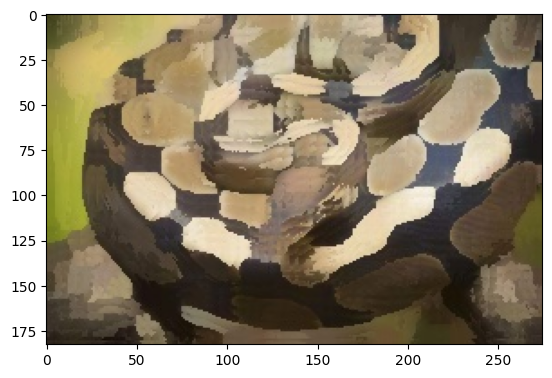

In [27]:
test = cv2.imread('filtered_image_5.jpg')
filtered_image_rgb = cv2.cvtColor(test, cv2.COLOR_BGR2RGB)
plt.imshow(filtered_image_rgb)

# Using GPU - without shared mem

## GPU setup

In [28]:
import numpy as np
import numba
from numba import cuda
import matplotlib.pyplot as plt
from matplotlib.image import imread
import time

In [29]:
from numba.typed import List

#scale image [0..255] to [0..1]
@cuda.jit(nopython=True)
def scale(x):
  x = x/255
  return x

#find max and min
@cuda.jit(nopython=True)
def min_and_max(red, green, blue, src):
  #find max
  if red > green and red > blue:
    max_c = (red, 0)
  elif green > red and green > blue:
    max_c = (green, 1)
  else:
    max_c = (blue, 2)

  #find min
  if red < green and red < blue:
    min_c = (red, 0)
  elif green < red and green < blue:
    min_c = (green, 1)
  else:
    min_c = (blue, 2)

  delta = max_c[0] - min_c[0]

  return (max_c, min_c, delta)

In [30]:
@cuda.jit
def rgb2hsv_gpu(src, dst):
    tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
    g = np.float32(((src[tidx, 0] + src[tidx, 1] + src[tidx, 2]) / 3))

    red = scale(np.float32(src[tidx, 0]))
    green = scale(np.float32(src[tidx, 1]))
    blue = scale(np.float32(src[tidx, 2]))

    # min_c, max_c, delta = min_and_max(red, green, blue, src)
    max_c, min_c, delta = min_and_max(red, green, blue, src)
    H = 0
    S = 0
    V = 0
    if delta == 0:
      H = 0
    elif max_c[1] == 0:
      H = 60*(((green-blue)/delta)%6)
    elif max_c[1] == 1:
      H = 60*(((blue-red)/delta)+2)
    else:
      H = 60*(((red-green)/delta)+4)

    if max_c[0] == 0:
      S = 0
    else:
      S = delta/max_c[0]

    V = max_c[0]

    dst[tidx, 0] = H
    dst[tidx, 1] = S
    dst[tidx, 2] = V

In [31]:
@cuda.jit
def hsv2rgb_gpu(src, dst):
    tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x

    H = src[tidx, 0]
    S = src[tidx, 1]
    V = src[tidx, 2]

    d = H/60
    hi = int(d)%6
    f = d - hi

    l = V*(1-S)
    m = V*(1-f*S)
    n = V*(1-(1-f)*S)

    if H>=0 and H < 60:
      first_c = V
      second_c = n
      third_c = l
    elif H >= 60 and H < 120:
      first_c = m
      second_c = V
      third_c = l
    elif H >= 120 and H < 180:
      first_c = l
      second_c = V
      third_c = n
    elif H >= 180 and H < 240:
      first_c = l
      second_c = m
      third_c = V
    elif H >= 240 and H < 300:
      first_c = n
      second_c = l
      third_c = V
    else:
      first_c = V
      second_c = l
      third_c = m

    dst[tidx, 0] = first_c*255
    dst[tidx, 1] = second_c*255
    dst[tidx, 2] = third_c*255

## GPU filter

## new effort

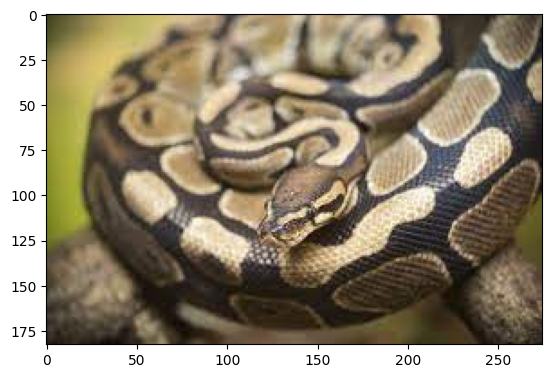

In [32]:
import numpy as np
import numba
from numba import cuda
import matplotlib.pyplot as plt
from matplotlib.image import imread
import time

rgb_image_new = imread('python.jpg')
plt.imshow(rgb_image_new)

In [33]:
# Flatten the image into a 1D array of RGB
imageWidth, imageHeight = rgb_image_new.shape[0], rgb_image_new.shape[1]
pixel_count = imageWidth * imageHeight
blockSize = 1024
gridSize = int(pixel_count / blockSize)

In [34]:
rgb_flat_gpu = rgb_image_new.reshape(pixel_count, 3)
rgb_flat_gpu.shape

(50325, 3)

In [35]:
start_time_gpu = time.time()
devSrc_part2 = cuda.to_device(rgb_flat_gpu)
devDst_part2 = cuda.device_array((pixel_count, 3), np.float32)
rgb2hsv_gpu[gridSize, blockSize](devSrc_part2, devDst_part2)
hostDst = devDst_part2.copy_to_host()
gpu_time = time.time() - start_time_gpu

/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 49 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


In [36]:
hsv_image_part2 = hostDst.reshape(imageWidth, imageHeight, 3)

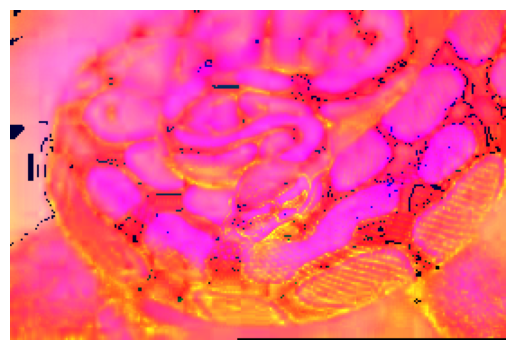

In [37]:
plt.imshow(hsv_image_part2)
plt.axis('off')
plt.show()

### using this hsv image as a base

In [38]:
# # the src will be my initial rgb image and the hsv will be use for the shared mem later
# @cuda.jit
# def kuwahara_filter_new(src, dst, window_size):
#     tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
#     tidy = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y

#     # H = scale(np.float32(src[tidx, 0]))
#     # S = scale(np.float32(src[tidx, 1]))
#     # V = scale(np.float32(src[tidx, 2]))

#     # =============================================
#     # for i in range(window_size, imageHeight + window_size): # start at pad and end at h + pad (+pad is the start one)
#     #     for j in range(window_size, imageWidth + window_size):
#     windows = [
#         src[tidx-window_size:tidx+1, tidy-window_size:tidy+1],
#         src[tidx:tidx+window_size+1, tidy-window_size:tidy+1],
#         src[tidx-window_size:tidx+1, tidy:tidy+window_size+1],
#         src[tidx:tidx+window_size+1, tidy:tidy+window_size+1]
#     ]
#     hsv_windows = [
#         hsv_image_part2[tidx-window_size:tidx+1, tidy-window_size:tidy+1, 2],
#         hsv_image_part2[tidx:tidx+window_size+1, tidy-window_size:tidy+1, 2],
#         hsv_image_part2[tidx-window_size:tidx+1, tidy:tidy+window_size+1, 2],
#         hsv_image_part2[tidx:tidx+window_size+1, tidy:tidy+window_size+1, 2]
#     ]

#     # # find the window with the lowest standard deviation of brightness
#     # std_devs = [np.std(win) for win in hsv_windows]
#     # best_win = windows[np.argmin(std_devs)]

#     # find the window with the lowest standard deviation of brightness
#     std_devs = []
#     for win in hsv_windows:
#         mean = win.sum() / win.size
#         std_dev = np.sqrt(((win - mean)**2).sum() / win.size)
#         std_devs.append(std_dev)
#     best_win = windows[np.argmin(std_devs)]

#     # assign the mean RGB value of this window to the output pixel
#     # dst[tidx-window_size, tidy-window_size] = np.mean(np.mean(best_win, axis=0), axis=0)
#     mean_rgb = best_win.sum(axis=(0, 1)) / (best_win.shape[0] * best_win.shape[1])
#     dst[tidx-window_size, tidy-window_size] = mean_rgb
#     # =============================================

#     # dst[tidx, 0] = H
#     # dst[tidx, 1] = S
#     # dst[tidx, 2] = V
#     # dst[tidx, tidy, 0] = dst[tidx, tidy, 1] = dst[tidx, tidy, 2] = g

In [39]:
# import math

# @cuda.jit
# def kuwahara_filter_new(src, dst, v_chanel, window_size):
#     tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
#     tidy = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y

#     # test win1
#     # hsv1 = hsv_image_part2[tidx-window_size:tidx, tidy-window_size:tidy, 2]
#     sum_window1 = np.float32(0)
#     for i in range(tidx-window_size, tidx):
#       for j in range(tidy-window_size, tidy):
#           sum_window1 += v_chanel[i, j]
#     mean_w1 = sum_window1/(window_size*window_size)

#     sosd1 = np.float32(0)

#     for i in range(tidx-window_size, tidx):
#       for j in range(tidy-window_size, tidy):
#           sosd1 += (v_chanel[i, j] - mean_w1)*(v_chanel[i, j] - mean_w1)

#     std_dev1 = math.sqrt(sosd1/(window_size*window_size))
#     # test win2
#     # hsv2 = hsv_image_part2[tidx:tidx+window_size, tidy-window_size:tidy, 2]
#     sum_window2 = np.float32(0)
#     for i in range(tidx,tidx+window_size):
#       for j in range(tidy-window_size,tidy):
#           sum_window2 += v_chanel[i, j]
#     mean_w2 = sum_window2/(window_size*window_size)

#     sosd2 = np.float32(0)

#     for i in range(tidx,tidx+window_size):
#       for j in range(tidy-window_size,tidy):
#           sosd2 += (v_chanel[i, j] - mean_w2)*(v_chanel[i, j] - mean_w2)

#     std_dev2 = math.sqrt(sosd2/(window_size*window_size))
#     # test win3
#     # hsv3 = hsv_image_part2[tidx-window_size:tidx, tidy:tidy+window_size, 2]
#     sum_window3 = np.float32(0)
#     for i in range(tidx-window_size,tidx):
#       for j in range(tidy,tidy+window_size):
#           sum_window3 += v_chanel[i, j]
#     mean_w3 = sum_window3/(window_size*window_size)

#     sosd3 = np.float32(0)

#     for i in range(tidx-window_size,tidx):
#       for j in range(tidy,tidy+window_size):
#           sosd3 += (v_chanel[i, j] - mean_w3)*(v_chanel[i, j] - mean_w3)

#     std_dev3 = math.sqrt(sosd3/(window_size*window_size))
#     # test win4
#     # hsv4 = hsv_image_part2[tidx:tidx+window_size, tidy:tidy+window_size, 2]
#     sum_window4 = np.float32(0)
#     for i in range(tidx,tidx+window_size):
#       for j in range(tidy,tidy+window_size):
#           sum_window4 += v_chanel[i, j]
#     mean_w4 = sum_window4/(window_size*window_size)

#     sosd4 = np.float32(0)

#     for i in range(tidx,tidx+window_size):
#       for j in range(tidy,tidy+window_size):
#           sosd4 += (v_chanel[i, j] - mean_w4)*(v_chanel[i, j] - mean_w4)

#     std_dev4 = math.sqrt(sosd4/(window_size*window_size))

#     # till here, i have my 4 windows
#     min_std_dev = min(std_dev1, std_dev2, std_dev3, std_dev4)

#     R = np.float32(0)
#     B = np.float32(0)
#     G = np.float32(0)

#     if std_dev1 == min_std_dev:
#       for i in range(tidx-window_size, tidx):
#         for j in range(tidy-window_size, tidy):
#               R += src[i, j, 0]
#               G += src[i, j, 1]
#               B += src[i, j, 2]

#       dst[tidx, tidy, 0] = R / (window_size*window_size)
#       dst[tidx, tidy, 1] = G / (window_size*window_size)
#       dst[tidx, tidy, 2] = B / (window_size*window_size)

#     if std_dev2 == min_std_dev:
#       for i in range(tidx,tidx+window_size):
#         for j in range(tidy-window_size,tidy):
#               R += src[i, j, 0]
#               G += src[i, j, 1]
#               B += src[i, j, 2]

#       dst[tidx, tidy, 0] = R / (window_size*window_size)
#       dst[tidx, tidy, 1] = G / (window_size*window_size)
#       dst[tidx, tidy, 2] = B / (window_size*window_size)

#     if std_dev3 == min_std_dev:
#       for i in range(tidx-window_size,tidx):
#         for j in range(tidy,tidy+window_size):
#               R += src[i, j, 0]
#               G += src[i, j, 1]
#               B += src[i, j, 2]

#       dst[tidx, tidy, 0] = R / (window_size*window_size)
#       dst[tidx, tidy, 1] = G / (window_size*window_size)
#       dst[tidx, tidy, 2] = B / (window_size*window_size)

#     if std_dev4 == min_std_dev:
#       for i in range(tidx,tidx+window_size):
#         for j in range(tidy,tidy+window_size):
#               R += src[i, j, 0]
#               G += src[i, j, 1]
#               B += src[i, j, 2]

#       dst[tidx, tidy, 0] = R / (window_size*window_size)
#       dst[tidx, tidy, 1] = G / (window_size*window_size)
#       dst[tidx, tidy, 2] = B / (window_size*window_size)

# # Flatten the image into a 1D array of RGB
# imageWidth, imageHeight  = rgb_image_new.shape[0], rgb_image_new.shape[1]
# pixel_count = imageWidth * imageHeight

# blockDim = (16, 16)
# gridDim = ((imageWidth // blockDim[0]) + 1, (imageHeight // blockDim[1]) + 1)

# v_arr = hsv_image_part2[:, :, 2]
# v_arr = np.ascontiguousarray(v_arr)

# devSrc = cuda.to_device(rgb_image_new)
# devDst = cuda.device_array((imageWidth, imageHeight, 3), np.float32)
# v_chanel = cuda.to_device(v_arr)

# start_time_gpu = time.time()
# # grayscale[gridSize, blockSize](devSrc, devDst)
# kuwahara_filter_new[gridDim, blockDim](devSrc, devDst, v_chanel, 5)
# hostDst = devDst.copy_to_host()
# gpu_time = time.time() - start_time_gpu

# new_image_kuwahara = hostDst.reshape(imageWidth, imageHeight, 3)

# plt.imshow(new_image_kuwahara)
# # plt.axis('off')
# plt.show()

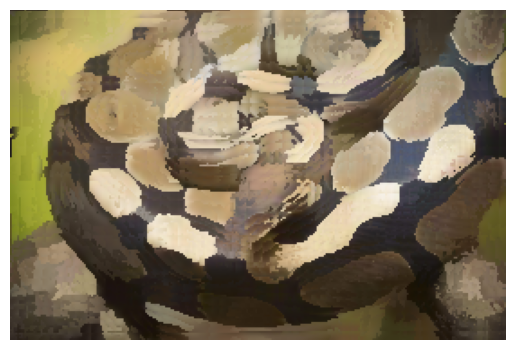

In [40]:
import math

@cuda.jit
def kuwahara_filter_new(src, dst, v_arr, window_size):
    tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
    tidy = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y

    # test win1
    # hsv1 = hsv_image_part2[tidx-window_size:tidx, tidy-window_size:tidy, 2]
    sum_window1 = np.float32(0)
    for i in range(tidx-window_size, tidx):
      for j in range(tidy-window_size, tidy):
          sum_window1 += v_arr[i, j]
    mean_w1 = sum_window1/(window_size*window_size)

    sosd1 = np.float32(0)

    for i in range(tidx-window_size, tidx):
      for j in range(tidy-window_size, tidy):
          sosd1 += (v_arr[i, j] - mean_w1)*(v_arr[i, j] - mean_w1)

    std_dev1 = math.sqrt(sosd1/(window_size*window_size))
    # test win2
    # hsv2 = hsv_image_part2[tidx:tidx+window_size, tidy-window_size:tidy, 2]
    sum_window2 = np.float32(0)
    for i in range(tidx,tidx+window_size):
      for j in range(tidy-window_size,tidy):
          sum_window2 += v_arr[i, j]
    mean_w2 = sum_window2/(window_size*window_size)

    sosd2 = np.float32(0)

    for i in range(tidx,tidx+window_size):
      for j in range(tidy-window_size,tidy):
          sosd2 += (v_arr[i, j] - mean_w2)*(v_arr[i, j] - mean_w2)

    std_dev2 = math.sqrt(sosd2/(window_size*window_size))
    # test win3
    # hsv3 = hsv_image_part2[tidx-window_size:tidx, tidy:tidy+window_size, 2]
    sum_window3 = np.float32(0)
    for i in range(tidx-window_size,tidx):
      for j in range(tidy,tidy+window_size):
          sum_window3 += v_arr[i, j]
    mean_w3 = sum_window3/(window_size*window_size)

    sosd3 = np.float32(0)

    for i in range(tidx-window_size,tidx):
      for j in range(tidy,tidy+window_size):
          sosd3 += (v_arr[i, j] - mean_w3)*(v_arr[i, j] - mean_w3)

    std_dev3 = math.sqrt(sosd3/(window_size*window_size))
    # test win4
    # hsv4 = hsv_image_part2[tidx:tidx+window_size, tidy:tidy+window_size, 2]
    sum_window4 = np.float32(0)
    for i in range(tidx,tidx+window_size):
      for j in range(tidy,tidy+window_size):
          sum_window4 += v_arr[i, j]
    mean_w4 = sum_window4/(window_size*window_size)

    sosd4 = np.float32(0)

    for i in range(tidx,tidx+window_size):
      for j in range(tidy,tidy+window_size):
          sosd4 += (v_arr[i, j] - mean_w4)*(v_arr[i, j] - mean_w4)

    std_dev4 = math.sqrt(sosd4/(window_size*window_size))

    # till here, i have my 4 windows
    min_std_dev = min(std_dev1, std_dev2, std_dev3, std_dev4)

    R = np.float32(0)
    B = np.float32(0)
    G = np.float32(0)

    if std_dev1 == min_std_dev:
      for i in range(tidx-window_size, tidx):
        for j in range(tidy-window_size, tidy):
              R += src[i, j, 0]
              G += src[i, j, 1]
              B += src[i, j, 2]

      dst[tidx, tidy, 0] = np.uint8(R / (window_size*window_size))
      dst[tidx, tidy, 1] = np.uint8(G / (window_size*window_size))
      dst[tidx, tidy, 2] = np.uint8(B / (window_size*window_size))

    if std_dev2 == min_std_dev:
      for i in range(tidx,tidx+window_size):
        for j in range(tidy-window_size,tidy):
              R += src[i, j, 0]
              G += src[i, j, 1]
              B += src[i, j, 2]

      dst[tidx, tidy, 0] = np.uint8(R / (window_size*window_size))
      dst[tidx, tidy, 1] = np.uint8(G / (window_size*window_size))
      dst[tidx, tidy, 2] = np.uint8(B / (window_size*window_size))

    if std_dev3 == min_std_dev:
      for i in range(tidx-window_size,tidx):
        for j in range(tidy,tidy+window_size):
              R += src[i, j, 0]
              G += src[i, j, 1]
              B += src[i, j, 2]

      dst[tidx, tidy, 0] = np.uint8(R / (window_size*window_size))
      dst[tidx, tidy, 1] = np.uint8(G / (window_size*window_size))
      dst[tidx, tidy, 2] = np.uint8(B / (window_size*window_size))

    if std_dev4 == min_std_dev:
      for i in range(tidx,tidx+window_size):
        for j in range(tidy,tidy+window_size):
              R += src[i, j, 0]
              G += src[i, j, 1]
              B += src[i, j, 2]

      # dst[tidx, tidy, 0] = R / (window_size*window_size)
      # dst[tidx, tidy, 1] = G / (window_size*window_size)
      # dst[tidx, tidy, 2] = B / (window_size*window_size)

      dst[tidx, tidy, 0] = np.uint8(R / (window_size*window_size))
      dst[tidx, tidy, 1] = np.uint8(G / (window_size*window_size))
      dst[tidx, tidy, 2] = np.uint8(B / (window_size*window_size))

# Flatten the image into a 1D array of RGB
imageWidth, imageHeight  = rgb_image_new.shape[0], rgb_image_new.shape[1]
pixel_count = imageWidth * imageHeight

blockDim = (16, 16)
gridDim = ((imageWidth // blockDim[0]) + 1, (imageHeight // blockDim[1]) + 1)

# v_arr = hsv_image_part2[tidx-window_size:tidx, tidy-window_size:tidy, 2]

v_arr = hsv_image_part2[:, :, 2]
v_arr = np.ascontiguousarray(v_arr)

devSrc = cuda.to_device(rgb_image_new)
devDst = cuda.device_array((imageWidth, imageHeight, 3), np.uint8)
cuda_v_arr = cuda.to_device(v_arr)
# v_chanel = cuda.to_device(v_arr)
# grayscale[gridSize, blockSize](devSrc, devDst)
start_time_gpu = time.time()
kuwahara_filter_new[gridDim, blockDim](devSrc, devDst, cuda_v_arr, 5)
hostDst = devDst.copy_to_host()
gpu_time = time.time() - start_time_gpu

new_image_kuwahara = hostDst.reshape(imageWidth, imageHeight, 3)

plt.imshow(new_image_kuwahara)
plt.axis('off')
plt.show()

In [41]:
gpu_time

1.739546537399292

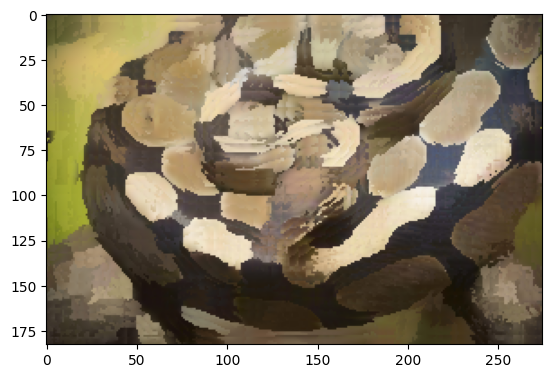

In [42]:
plt.imshow(new_image_kuwahara)
# plt.axis('off')
plt.show()

In [43]:
# stop here

# Using GPU - with shared memory

In [44]:
import numpy as np
import numba
from numba import cuda
import matplotlib.pyplot as plt
from matplotlib.image import imread
import time

from numba.typed import List

#scale image [0..255] to [0..1]
@cuda.jit(nopython=True)
def scale(x):
  x = x/255
  return x

#find max and min
@cuda.jit(nopython=True)
def min_and_max(red, green, blue, src):
  #find max
  if red > green and red > blue:
    max_c = (red, 0)
  elif green > red and green > blue:
    max_c = (green, 1)
  else:
    max_c = (blue, 2)

  #find min
  if red < green and red < blue:
    min_c = (red, 0)
  elif green < red and green < blue:
    min_c = (green, 1)
  else:
    min_c = (blue, 2)

  delta = max_c[0] - min_c[0]

  return (max_c, min_c, delta)

@cuda.jit
def rgb2hsv_gpu(src, dst):
  tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
  g = np.float32(((src[tidx, 0] + src[tidx, 1] + src[tidx, 2]) / 3))

  red = scale(np.float32(src[tidx, 0]))
  green = scale(np.float32(src[tidx, 1]))
  blue = scale(np.float32(src[tidx, 2]))

  # min_c, max_c, delta = min_and_max(red, green, blue, src)
  max_c, min_c, delta = min_and_max(red, green, blue, src)
  H = 0
  S = 0
  V = 0
  if delta == 0:
    H = 0
  elif max_c[1] == 0:
    H = 60*(((green-blue)/delta)%6)
  elif max_c[1] == 1:
    H = 60*(((blue-red)/delta)+2)
  else:
    H = 60*(((red-green)/delta)+4)

  if max_c[0] == 0:
    S = 0
  else:
    S = delta/max_c[0]

  V = max_c[0]

  dst[tidx, 0] = H
  dst[tidx, 1] = S
  dst[tidx, 2] = V

@cuda.jit
def hsv2rgb_gpu(src, dst):
  tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x

  H = src[tidx, 0]
  S = src[tidx, 1]
  V = src[tidx, 2]

  d = H/60
  hi = int(d)%6
  f = d - hi

  l = V*(1-S)
  m = V*(1-f*S)
  n = V*(1-(1-f)*S)

  if H>=0 and H < 60:
    first_c = V
    second_c = n
    third_c = l
  elif H >= 60 and H < 120:
    first_c = m
    second_c = V
    third_c = l
  elif H >= 120 and H < 180:
    first_c = l
    second_c = V
    third_c = n
  elif H >= 180 and H < 240:
    first_c = l
    second_c = m
    third_c = V
  elif H >= 240 and H < 300:
    first_c = n
    second_c = l
    third_c = V
  else:
    first_c = V
    second_c = l
    third_c = m

  dst[tidx, 0] = first_c*255
  dst[tidx, 1] = second_c*255
  dst[tidx, 2] = third_c*255

## 1st try

### convert to hsv

/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 49 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


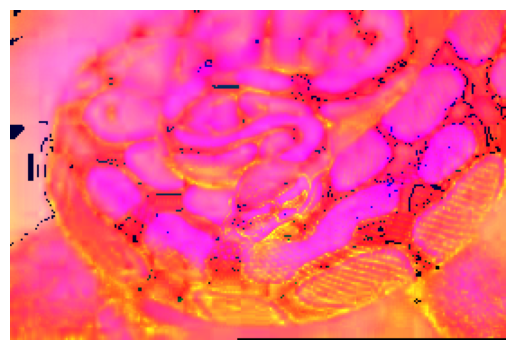

In [45]:
import numpy as np
import numba
from numba import cuda
import matplotlib.pyplot as plt
from matplotlib.image import imread
import time

rgb_image_new = imread('python.jpg')
plt.imshow(rgb_image_new)

# Flatten the image into a 1D array of RGB
imageWidth, imageHeight = rgb_image_new.shape[0], rgb_image_new.shape[1]
pixel_count = imageWidth * imageHeight
blockSize = 1024
gridSize = int(pixel_count / blockSize)

rgb_flat_gpu = rgb_image_new.reshape(pixel_count, 3)
rgb_flat_gpu.shape

start_time_gpu = time.time()
devSrc_part2 = cuda.to_device(rgb_flat_gpu)
devDst_part2 = cuda.device_array((pixel_count, 3), np.float32)
rgb2hsv_gpu[gridSize, blockSize](devSrc_part2, devDst_part2)
hostDst = devDst_part2.copy_to_host()
gpu_time = time.time() - start_time_gpu

hsv_image_part2 = hostDst.reshape(imageWidth, imageHeight, 3)

plt.imshow(hsv_image_part2)
plt.axis('off')
plt.show()


### applying the filter

In [46]:
v_arr = hsv_image_part2[:, :, 2]
v_arr.shape

(183, 275)

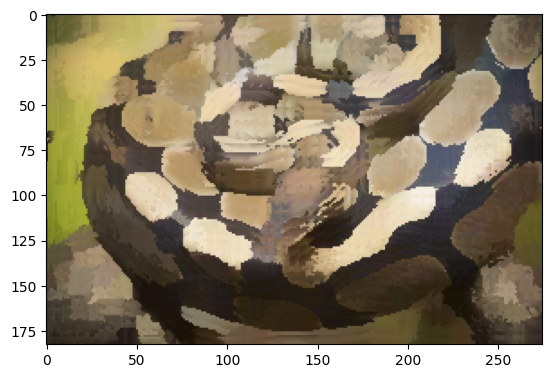

In [47]:
import math

@cuda.jit
def kuwahara_filter_new(src, dst, v_chanel, window_size, shape0, shape1):
  tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
  tidy = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y

  # shared = cuda.shared.array((np.uint8(shape0), np.uint8(shape1)), numba.uint8)
  shared = cuda.shared.array((183, 275), numba.uint8)
  shared = v_chanel
  cuda.syncthreads()

  # test win1
  # hsv1 = hsv_image_part2[tidx-window_size:tidx, tidy-window_size:tidy, 2]
  sum_window1 = np.float32(0)
  for i in range(tidx-window_size, tidx):
    for j in range(tidy-window_size, tidy):
        sum_window1 += shared[i, j]
  mean_w1 = sum_window1/(window_size*window_size)

  sosd1 = np.float32(0)

  for i in range(tidx-window_size, tidx):
    for j in range(tidy-window_size, tidy):
        sosd1 += (shared[i, j] - mean_w1)*(shared[i, j] - mean_w1)

  std_dev1 = math.sqrt(sosd1/(window_size*window_size))
  # test win2
  # hsv2 = hsv_image_part2[tidx:tidx+window_size, tidy-window_size:tidy, 2]
  sum_window2 = np.float32(0)
  for i in range(tidx,tidx+window_size):
    for j in range(tidy-window_size,tidy):
        sum_window2 += shared[i, j]
  mean_w2 = sum_window2/(window_size*window_size)

  sosd2 = np.float32(0)

  for i in range(tidx,tidx+window_size):
    for j in range(tidy-window_size,tidy):
        sosd2 += (shared[i, j] - mean_w2)*(shared[i, j] - mean_w2)

  std_dev2 = math.sqrt(sosd2/(window_size*window_size))
  # test win3
  # hsv3 = hsv_image_part2[tidx-window_size:tidx, tidy:tidy+window_size, 2]
  sum_window3 = np.float32(0)
  for i in range(tidx-window_size,tidx):
    for j in range(tidy,tidy+window_size):
        sum_window3 += shared[i, j]
  mean_w3 = sum_window3/(window_size*window_size)

  sosd3 = np.float32(0)

  for i in range(tidx-window_size,tidx):
    for j in range(tidy,tidy+window_size):
        sosd3 += (shared[i, j] - mean_w3)*(shared[i, j] - mean_w3)

  std_dev3 = math.sqrt(sosd3/(window_size*window_size))
  # test win4
  # hsv4 = hsv_image_part2[tidx:tidx+window_size, tidy:tidy+window_size, 2]
  sum_window4 = np.float32(0)
  for i in range(tidx,tidx+window_size):
    for j in range(tidy,tidy+window_size):
        sum_window4 += shared[i, j]
  mean_w4 = sum_window4/(window_size*window_size)

  sosd4 = np.float32(0)

  for i in range(tidx,tidx+window_size):
    for j in range(tidy,tidy+window_size):
        sosd4 += (shared[i, j] - mean_w4)*(shared[i, j] - mean_w4)

  std_dev4 = math.sqrt(sosd4/(window_size*window_size))

  # till here, i have my 4 windows
  min_std_dev = min(std_dev1, std_dev2, std_dev3, std_dev4)

  R = np.float32(0)
  B = np.float32(0)
  G = np.float32(0)

  if std_dev1 == min_std_dev:
    for i in range(tidx-window_size, tidx):
      for j in range(tidy-window_size, tidy):
            R += src[i, j, 0]
            G += src[i, j, 1]
            B += src[i, j, 2]

    dst[tidx, tidy, 0] = R / (window_size*window_size)
    dst[tidx, tidy, 1] = G / (window_size*window_size)
    dst[tidx, tidy, 2] = B / (window_size*window_size)

  if std_dev2 == min_std_dev:
    for i in range(tidx,tidx+window_size):
      for j in range(tidy-window_size,tidy):
            R += src[i, j, 0]
            G += src[i, j, 1]
            B += src[i, j, 2]

    dst[tidx, tidy, 0] = R / (window_size*window_size)
    dst[tidx, tidy, 1] = G / (window_size*window_size)
    dst[tidx, tidy, 2] = B / (window_size*window_size)

  if std_dev3 == min_std_dev:
    for i in range(tidx-window_size,tidx):
      for j in range(tidy,tidy+window_size):
            R += src[i, j, 0]
            G += src[i, j, 1]
            B += src[i, j, 2]

    dst[tidx, tidy, 0] = R / (window_size*window_size)
    dst[tidx, tidy, 1] = G / (window_size*window_size)
    dst[tidx, tidy, 2] = B / (window_size*window_size)

  if std_dev4 == min_std_dev:
    for i in range(tidx,tidx+window_size):
      for j in range(tidy,tidy+window_size):
            R += src[i, j, 0]
            G += src[i, j, 1]
            B += src[i, j, 2]

    dst[tidx, tidy, 0] = R / (window_size*window_size)
    dst[tidx, tidy, 1] = G / (window_size*window_size)
    dst[tidx, tidy, 2] = B / (window_size*window_size)

# Flatten the image into a 1D array of RGB
imageWidth, imageHeight  = rgb_image_new.shape[0], rgb_image_new.shape[1]
pixel_count = imageWidth * imageHeight

blockDim = (16, 16)
gridDim = ((imageWidth // blockDim[0]) + 1, (imageHeight // blockDim[1]) + 1)

v_arr = hsv_image_part2[:, :, 2]
v_arr = np.ascontiguousarray(v_arr)

devSrc = cuda.to_device(rgb_image_new)
devDst = cuda.device_array((imageWidth, imageHeight, 3), np.uint8)
v_chanel = cuda.to_device(v_arr)

start_time_gpu = time.time()
# grayscale[gridSize, blockSize](devSrc, devDst)
kuwahara_filter_new[gridDim, blockDim](devSrc, devDst, v_chanel, 5, v_arr.shape[0], v_arr.shape[1]) #, shape0=v_arr.shape[0], shape1=v_arr.shape[1]
hostDst = devDst.copy_to_host()
gpu_time = time.time() - start_time_gpu

new_image_kuwahara = hostDst.reshape(imageWidth, imageHeight, 3)

plt.imshow(new_image_kuwahara)
# plt.axis('off')
plt.show()

In [48]:
gpu_time

1.2679941654205322

# Testing

In [49]:
hsv_img = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2HSV)

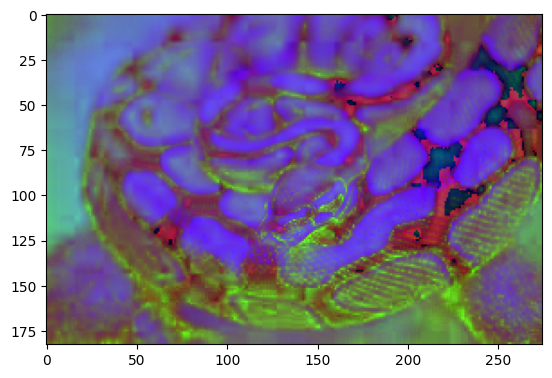

In [50]:
plt.imshow(hsv_img)

In [51]:
rgb_image_1 = cv2.cvtColor(hsv_img, cv2.COLOR_HSV2RGB)

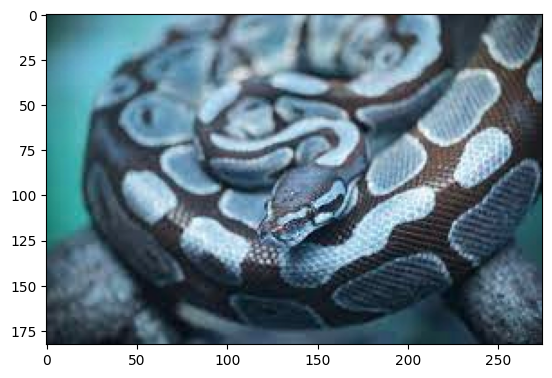

In [52]:
plt.imshow(rgb_image_1)